#0 Preparations

Installing required packages


In [ ]:
!pip install fastapi==0.75.1
!pip install pandas==1.4.2
!pip install sqlalchemy==1.4.35
!pip install requests==2.27.1
!pip install numpy==1.22.4
!pip install pydantic==1.9.1
!pip install psycopg2-binary==2.9.3
!pip install uvicorn==0.16.0
!pip install category-encoders==2.5.0
!pip install loguru==0.6.0
!pip install implicit==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

In [ ]:
!pip install psycopg2-binary==2.9.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install catboost==1.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import required packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import string
import warnings

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sqlalchemy import create_engine
from sqlalchemy import text

# 1 Connect to SQL DB and download data

Init function to load large amount of data from sql db

In [ ]:
def batch_load_sql(query: str, engine) -> pd.DataFrame:
    CHUNKSIZE = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(text(query), conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

Create connection and download data from sql db

In [ ]:
engine = create_engine('###')

#user_data = batch_load_sql('SELECT * FROM public.user_data', engine=engine)

post_text_df = batch_load_sql('SELECT * FROM public.post_text_df', engine=engine)

feed_data = batch_load_sql('SELECT * FROM public.feed_data LIMIT 300000', engine=engine)

# 2 Prepare user_data dataframe

In [ ]:
user_data = batch_load_sql("SELECT * FROM public.a_cherepaschuk_user_features_v2_lesson_22", engine=engine)

In [ ]:
user_data

,index,user_id,gender,age,country,city,exp_group,os,source,like_rate,most_active_dow,fav_topic_avg_chars,not_fav_topic,avg_actions_per_day,likes_count_from_last_week,likes_count_from_last_month
0,0,200,1,34,Russia,Degtyarsk,3,Android,ads,0.113428,2,1266.548333,business,1.460402,1.945910,2.833213
1,1,201,0,37,Russia,Abakan,0,Android,ads,0.080711,3,1266.548333,politics,1.324925,1.609438,3.258097
2,2,202,1,17,Russia,Smolensk,4,Android,ads,0.128022,2,1266.548333,business,1.564986,2.197225,3.135494
3,3,203,0,18,Russia,Moscow,1,iOS,ads,0.173979,5,1266.548333,entertainment,1.878771,2.055887,3.178054
4,4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,0.154151,3,1266.548333,tech,1.722767,1.945910,2.890372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,0.053776,5,1266.548333,business,1.036092,2.055887,2.079442
163201,163201,168549,0,18,Russia,Tula,2,Android,organic,0.083699,3,2662.388489,sport,1.321756,0.693147,1.791759
163202,163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,0.098017,6,1266.548333,sport,1.366876,2.055887,2.833213
163203,163203,168551,0,38,Russia,Moscow,3,iOS,organic,0.095882,1,1266.548333,tech,1.341174,1.791759,3.091042


In [ ]:
user_data = user_data.drop('index', axis=1)

In [ ]:
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [ ]:
post_info = batch_load_sql('SELECT * FROM public.a_cherepaschuk_post_features_v4_main_lesson_22', engine=engine)

In [ ]:
post_info = post_info.drop('index', axis=1)

In [ ]:
post_info

,post_id,topic,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,1,business,0.363151,0.048938,-0.264081,-0.160672,-0.211844,-0.207537,0.325393,-0.026139,...,0.349080,0.290132,-0.244970,0.078532,0.137399,0.208097,-0.058624,-0.141593,0.015918,0.000092
1,2,business,0.236416,-0.159501,-0.327798,-0.372885,-0.292128,-0.019028,0.333677,-0.179642,...,0.311639,0.297819,-0.177003,0.130227,-0.063239,0.190171,-0.018153,-0.289936,0.119365,-0.001623
2,3,business,0.375191,-0.113944,-0.240547,-0.282425,-0.264252,0.061839,0.249180,0.019152,...,0.353616,0.308457,-0.207151,0.056724,0.056596,0.125301,0.021575,-0.338920,0.058694,-0.021266
3,4,business,0.273770,-0.048748,-0.440433,-0.189999,-0.410856,-0.100587,0.255757,0.036902,...,0.321182,0.218213,-0.267988,-0.093801,0.176987,0.251617,0.028331,-0.155708,0.136188,0.044055
4,5,business,0.297853,-0.073203,-0.146820,-0.127284,-0.133966,0.045766,0.176495,-0.218839,...,0.168949,0.208978,-0.051180,0.045685,0.173985,0.148893,0.097254,-0.239587,0.228066,0.189831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,movie,0.338545,0.084620,-0.225981,-0.115433,-0.064816,-0.129863,0.358163,-0.178001,...,0.495477,0.203647,-0.138003,0.148754,0.138934,0.199463,0.054088,-0.110224,0.039229,-0.003550
7019,7316,movie,0.354057,0.053933,-0.099446,-0.161002,0.009353,-0.190430,0.258928,-0.199819,...,0.322798,0.176826,-0.154205,-0.010798,0.100222,0.093780,0.051934,-0.119376,0.182106,0.072430
7020,7317,movie,0.340383,0.066492,-0.163184,-0.115225,-0.102958,-0.181814,0.346562,-0.133692,...,0.372651,0.169435,-0.041522,-0.033723,0.047250,0.173592,-0.027378,-0.086563,0.203404,0.032091
7021,7318,movie,0.432092,0.011092,-0.117306,-0.123570,0.066756,-0.103376,0.243298,-0.241603,...,0.468103,0.156609,-0.054083,0.210478,0.116214,0.064117,0.084667,0.075401,0.102739,0.015274


Extract features from timestamp

In [ ]:
feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'])

feed_data['hour'] = feed_data['timestamp'].apply(lambda x: x.hour)
feed_data['month'] = feed_data['timestamp'].apply(lambda x: x.month)

In [ ]:
feed_data = feed_data.drop('action', axis=1)

In [ ]:
final_dataset = pd.merge(feed_data, post_info, how='left', on='post_id')
final_dataset.head(5)

,timestamp,user_id,post_id,target,hour,month,topic,0,1,2,...,758,759,760,761,762,763,764,765,766,767
0,2021-11-14 16:22:58,108099,1702,0,16,11,sport,0.552017,-0.167809,-0.163248,...,0.370920,0.149879,-0.058292,0.202806,0.004337,0.248452,-0.066319,-0.054242,0.052454,0.176366
1,2021-11-14 16:23:59,108099,3626,1,16,11,covid,0.286424,0.047972,-0.162846,...,0.288390,0.316028,-0.020015,-0.035306,-0.020422,0.187707,-0.044807,-0.308044,0.205690,0.000869
2,2021-11-14 16:25:07,108099,3626,0,16,11,covid,0.286424,0.047972,-0.162846,...,0.288390,0.316028,-0.020015,-0.035306,-0.020422,0.187707,-0.044807,-0.308044,0.205690,0.000869
3,2021-11-14 16:25:09,108099,2906,0,16,11,covid,0.352986,0.057399,-0.133621,...,0.227974,0.327952,-0.116783,-0.078521,0.065393,0.181794,0.086524,-0.294518,0.409714,0.053533
4,2021-11-14 16:25:20,108099,6124,0,16,11,movie,0.363160,0.035033,-0.159031,...,0.420309,0.078592,-0.114637,0.058218,0.115202,0.144549,0.047427,-0.216747,0.162055,0.092913


In [ ]:
final_dataset = pd.merge(final_dataset, user_data, how='left', on='user_id')
final_dataset.head(5)

,timestamp,user_id,post_id,target,hour,month,topic,0,1,2,...,exp_group,os,source,like_rate,most_active_dow,fav_topic_avg_chars,not_fav_topic,avg_actions_per_day,likes_count_from_last_week,likes_count_from_last_month
0,2021-11-14 16:22:58,108099,1702,0,16,11,sport,0.552017,-0.167809,-0.163248,...,4,Android,organic,0.19403,2,1266.548333,business,1.928961,1.94591,3.465736
1,2021-11-14 16:23:59,108099,3626,1,16,11,covid,0.286424,0.047972,-0.162846,...,4,Android,organic,0.19403,2,1266.548333,business,1.928961,1.94591,3.465736
2,2021-11-14 16:25:07,108099,3626,0,16,11,covid,0.286424,0.047972,-0.162846,...,4,Android,organic,0.19403,2,1266.548333,business,1.928961,1.94591,3.465736
3,2021-11-14 16:25:09,108099,2906,0,16,11,covid,0.352986,0.057399,-0.133621,...,4,Android,organic,0.19403,2,1266.548333,business,1.928961,1.94591,3.465736
4,2021-11-14 16:25:20,108099,6124,0,16,11,movie,0.363160,0.035033,-0.159031,...,4,Android,organic,0.19403,2,1266.548333,business,1.928961,1.94591,3.465736


In [ ]:
final_dataset = final_dataset.set_index(['user_id', 'post_id'])

#5 Model training

Prepare train and test data

In [ ]:
max(final_dataset.timestamp), min(final_dataset.timestamp)

(Timestamp('2021-12-29 23:48:26'), Timestamp('2021-10-01 06:02:00'))

In [ ]:
X_train = final_dataset[final_dataset['timestamp'] < '2021-12-15'].drop(['timestamp','target'], axis=1)
X_test = final_dataset[final_dataset['timestamp'] >= '2021-12-15'].drop(['timestamp','target'], axis=1)

y_train = final_dataset[final_dataset['timestamp'] < '2021-12-15']['target']
y_test = final_dataset[final_dataset['timestamp'] >= '2021-12-15']['target']

In [ ]:
object_columns = [
    'topic', 'country', 'city', 'os',
    'source', 'not_fav_topic', 'hour', 'month', 'gender','most_active_dow', 'exp_group'
]

Train default catboost model

In [ ]:
base_model = CatBoostClassifier()
base_model.fit(X_train, y_train, object_columns)

Learning rate set to 0.108933
0:	learn: 0.6036575	total: 2.83s	remaining: 47m 8s
1:	learn: 0.5383546	total: 4.57s	remaining: 37m 58s
2:	learn: 0.4889485	total: 6.25s	remaining: 34m 38s
3:	learn: 0.4515578	total: 7.76s	remaining: 32m 13s
4:	learn: 0.4213601	total: 9.85s	remaining: 32m 41s
5:	learn: 0.4000672	total: 12.5s	remaining: 34m 26s
6:	learn: 0.3838363	total: 14.5s	remaining: 34m 11s
7:	learn: 0.3704924	total: 15.8s	remaining: 32m 38s
8:	learn: 0.3599396	total: 17s	remaining: 31m 16s
9:	learn: 0.3517694	total: 18.7s	remaining: 30m 54s
10:	learn: 0.3454978	total: 20.2s	remaining: 30m 15s
11:	learn: 0.3409467	total: 21.6s	remaining: 29m 36s
12:	learn: 0.3369653	total: 23.4s	remaining: 29m 36s
13:	learn: 0.3342535	total: 25.7s	remaining: 30m 8s
14:	learn: 0.3317410	total: 28.9s	remaining: 31m 39s
15:	learn: 0.3299369	total: 30.6s	remaining: 31m 19s
16:	learn: 0.3282180	total: 32s	remaining: 30m 50s
17:	learn: 0.3269970	total: 33.6s	remaining: 30m 35s
18:	learn: 0.3259440	total: 35.3

In [ ]:
print(f'ROC-AUC on train: {roc_auc_score(y_train, base_model.predict_proba(X_train)[:, 1])}')
print(f'ROC_AUC on test: {roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])}')

print(f'Accuracy on train: {accuracy_score(y_train, base_model.predict(X_train))}')
print(f'Accuracy on test: {accuracy_score(y_test, base_model.predict(X_test))}')


ROC-AUC on train: 0.5438722250409359
ROC_AUC on test: 0.6256777547948627
Accuracy on train: 0.896034088231653
Accuracy on test: 0.8780423867233974


In [ ]:
base_model.save_model('kc_project_rec_system_cb_model_v7',
                           format="cbm")

Feature importance

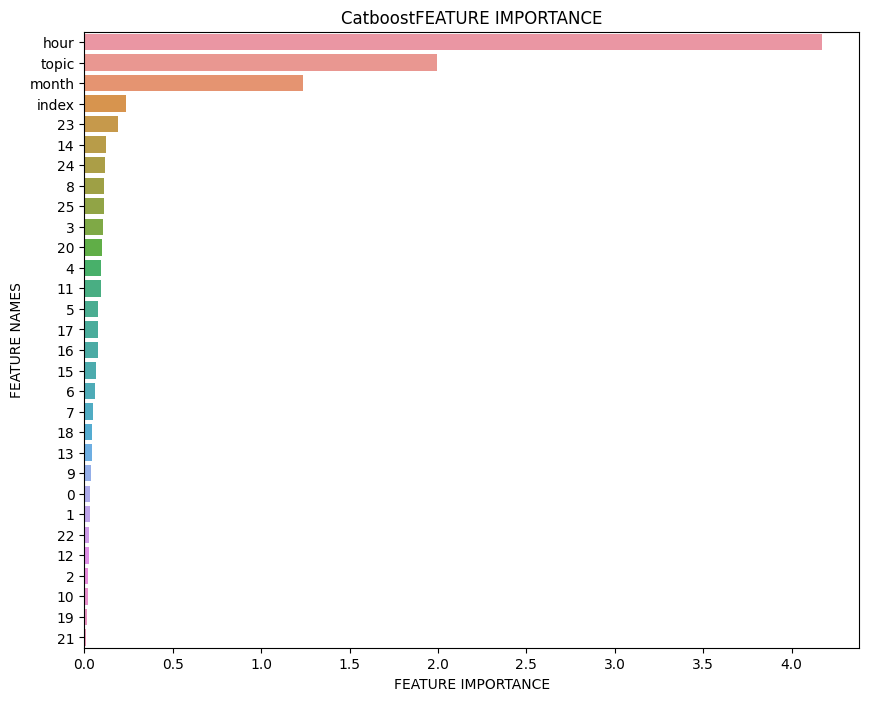

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)[:30]
    feature_names = np.array(names)[:30]

    data = {'feature_importance': feature_importance,
           'feature_names': feature_names}

    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by='feature_importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(base_model.feature_importances_, X_train.columns, 'Catboost')